# CRYPTOCURRENCY COMPARATIVE ANALYSIS -
Bitcoin (BTC) vs Ethereum (ETH)

This notebook walks through a comparative analysis of BTC and ETH,
with visualizations and explanations at each step.

- Trend Analysis
- Risk Profile Assessment
- Correlation Analysis


## IMPORT LIBRARIES AND LOAD DATA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the data
df = pd.read_csv('/content/crypto_data_20251019_142608.csv')
df['date'] = pd.to_datetime(df['date'])

## DATA EXPLORATION AND PREPARATION

Before any analysis, we need to understand our data structure, check for
missing values, and separate BTC and ETH data for comparison.

In [5]:
# Display first five rows
print("\n--- First Few Rows ---")
print(df.head())


--- First Few Rows ---
        date      coin         price        volume    market_cap  \
0 2024-10-20   bitcoin  68388.871290  1.411089e+10  1.351942e+12   
1 2024-10-20  ethereum   2649.979290  7.337170e+09  3.189754e+11   
2 2024-10-21  ethereum   2742.959141  1.269786e+10  3.301276e+11   
3 2024-10-21   bitcoin  68962.829180  1.725386e+10  1.362382e+12   
4 2024-10-22   bitcoin  67394.857757  4.048550e+10  1.332327e+12   

   daily_return          ma_7         ma_30  volatility_30d  cumulative_return  
0           NaN  68388.871290  68388.871290             NaN                NaN  
1           NaN   2649.979290   2649.979290             NaN                NaN  
2      0.035087   2696.469215   2696.469215             NaN           1.035087  
3      0.008393  68675.850235  68675.850235             NaN           1.008393  
4     -0.022736  68248.852742  68248.852742        0.022012           0.985465  


In [6]:
# Separate Bitcoin and Ethereum data
btc_data = df[df['coin'] == 'bitcoin'].sort_values('date').reset_index(drop=True)
eth_data = df[df['coin'] == 'ethereum'].sort_values('date').reset_index(drop=True)

In [7]:
print("\n--- Data Overview ---")
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of days: {df['date'].nunique()}")
print(f"\nBitcoin records: {len(btc_data)}")
print(f"Ethereum records: {len(eth_data)}")


--- Data Overview ---

Dataset shape: (732, 10)
Date range: 2024-10-20 00:00:00 to 2025-10-19 14:25:41
Number of days: 367

Bitcoin records: 366
Ethereum records: 366


In [8]:
print("\n--- Column Information ---")
print(df.info())


--- Column Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               732 non-null    datetime64[ns]
 1   coin               732 non-null    object        
 2   price              732 non-null    float64       
 3   volume             732 non-null    float64       
 4   market_cap         732 non-null    float64       
 5   daily_return       730 non-null    float64       
 6   ma_7               732 non-null    float64       
 7   ma_30              732 non-null    float64       
 8   volatility_30d     728 non-null    float64       
 9   cumulative_return  730 non-null    float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 57.3+ KB
None


In [9]:
print("\n--- Check for Missing Values ---")
print(df.isnull().sum())


--- Check for Missing Values ---
date                 0
coin                 0
price                0
volume               0
market_cap           0
daily_return         2
ma_7                 0
ma_30                0
volatility_30d       4
cumulative_return    2
dtype: int64


UNDERSTANDING MISSING VALUES:
- daily_return: First row for each coin is NaN (expected - no previous day)
- volatility_30d: First ~30 rows may be NaN (needs historical data)
- cumulative_return: First row is set to 1.0 (starting point)

These are expected for time series calculations!

HANDLING STRATEGY:

Most analysis functions automatically handle NaN by using `.dropna()`. For specific calculations, we'll use appropriate methods.

## PART A: COMPARATIVE TREND ANALYSIS

OBJECTIVE:
Compare price trends, performance, and trading patterns between BTC and ETH
to understand their historical behavior and current market position.


###A1. BASIC PRICE STATISTICS

Understanding basic price statistics gives us a foundation for comparison:
- Mean and median show typical price levels
- Min/max show the trading range
- Current price shows where we are now

In [10]:
def calculate_price_stats(data, coin_name):
    """Calculate and display basic price statistics."""
    print(f"\n{coin_name} Price Statistics:")
    print(f"  Current Price:    ${data['price'].iloc[-1]:,.2f}")
    print(f"  Mean Price:       ${data['price'].mean():,.2f}")
    print(f"  Median Price:     ${data['price'].median():,.2f}")
    print(f"  Min Price:        ${data['price'].min():,.2f}")
    print(f"  Max Price:        ${data['price'].max():,.2f}")
    print(f"  Price Range:      ${data['price'].max() - data['price'].min():,.2f}")

    # Calculate total return
    start_price = data['price'].iloc[0]
    end_price = data['price'].iloc[-1]
    total_return = ((end_price - start_price) / start_price) * 100
    print(f"  Total Return:     {total_return:+.2f}%")

    return total_return

In [11]:
# Calculate statistics for both coins
btc_return = calculate_price_stats(btc_data, "Bitcoin")
eth_return = calculate_price_stats(eth_data, "Ethereum")


Bitcoin Price Statistics:
  Current Price:    $108,386.94
  Mean Price:       $100,164.21
  Median Price:     $101,359.62
  Min Price:        $66,585.67
  Max Price:        $124,773.51
  Price Range:      $58,187.84
  Total Return:     +58.49%

Ethereum Price Statistics:
  Current Price:    $3,991.18
  Mean Price:       $3,066.34
  Median Price:     $2,993.22
  Min Price:        $1,471.36
  Max Price:        $4,829.23
  Price Range:      $3,357.86
  Total Return:     +50.61%


Compare the total returns to see which asset performed better over the period. A higher return doesn't necessarily mean better - we'll look at risk soon!


### A2. VISUALIZE RAW PRICE TRENDS

Visualizing raw prices helps us see:
- Overall price direction (uptrend, downtrend, sideways)
- Major price swings and volatility periods
- Visual comparison of magnitude

In [62]:
def plot_price_comparison(btc_data, eth_data):
    """Plot side-by-side price comparison."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Raw Price Trends: BTC vs ETH', fontsize=16, fontweight='bold')

    # Bitcoin
    ax1.plot(btc_data['date'], btc_data['price'],
             color='#F7931A', linewidth=2, label='Bitcoin')
    ax1.set_title('Bitcoin Price', fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (USD)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Ethereum
    ax2.plot(eth_data['date'], eth_data['price'],
             color='#627EEA', linewidth=2, label='Ethereum')
    ax2.set_title('Ethereum Price', fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price (USD)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

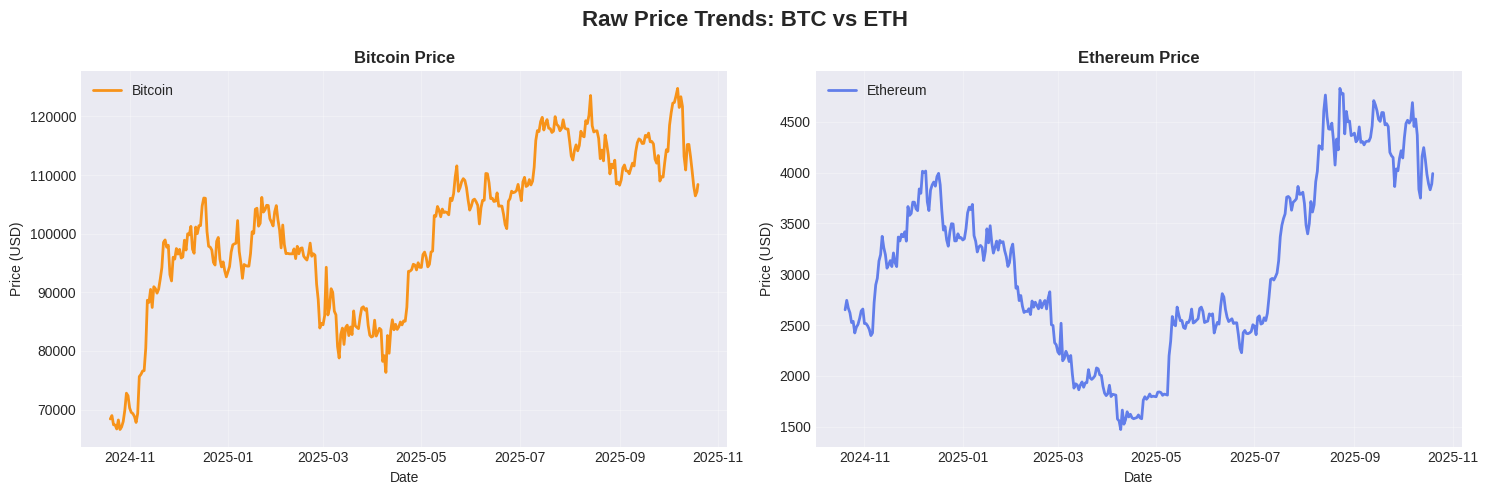

In [63]:
# Plot comparison
plot_price_comparison(btc_data, eth_data)

### A3. NORMALIZED PRICE COMPARISON
Since BTC (~$60,000) and ETH (~$3,000) trade at very different price levels,
we normalize both to start at 100. This shows percentage performance clearly.

Formula: Normalized Price = (Current Price / Starting Price) × 100

In [14]:
def plot_normalized_comparison(btc_data, eth_data):
    """Plot normalized price comparison starting at 100."""
    # Normalize prices to base 100
    btc_norm = (btc_data['price'] / btc_data['price'].iloc[0]) * 100
    eth_norm = (eth_data['price'] / eth_data['price'].iloc[0]) * 100

    plt.figure(figsize=(12, 6))
    plt.plot(btc_data['date'], btc_norm,
             label='Bitcoin', linewidth=2, color='#F7931A')
    plt.plot(eth_data['date'], eth_norm,
             label='Ethereum', linewidth=2, color='#627EEA')

    plt.title('Normalized Price Comparison (Base 100)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price (Base = 100)')
    plt.axhline(y=100, color='black', linestyle='--', alpha=0.3, label='Starting Point')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

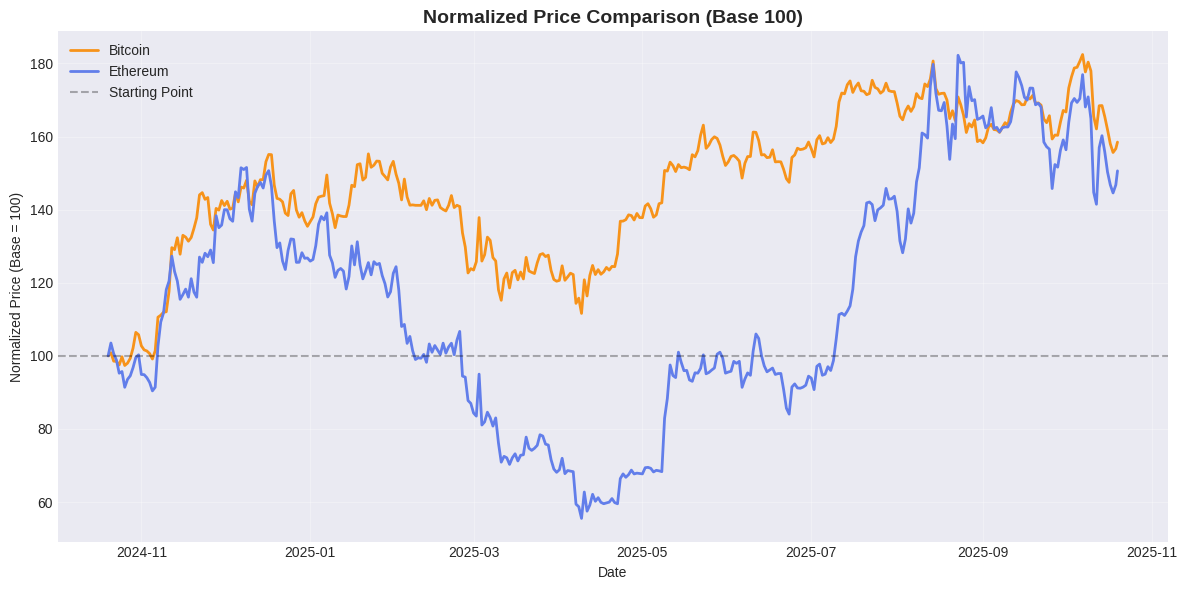

In [15]:
# Plot normalised comparison
plot_normalized_comparison(btc_data, eth_data)

#### Bitcoin Edged Out Ethereum in Total Return
Over the analysed period, Bitcoin provided a slightly better total return (+58.49%) compared to Ethereum's (+50.61%). The normalized price chart confirms this, showing Bitcoin (orange line) generally outperforming Ethereum (blue line) in percentage terms, especially during the sharp downturn and initial recovery in 2025.

However, Ethereum had a higher mean daily return (0.192%) than Bitcoin (0.153%). This suggests that while ETH had more positive days on average, its severe drawdowns (covered below) ultimately erased those gains, leading to a lower overall compounded return.

### A4. MOVING AVERAGES - TREND IDENTIFICATION

Moving averages smooth out price data to help identify trends:
- 7-Day MA: Short-term trend (weekly)
- 30-Day MA: Medium-term trend (monthly)

TRADING SIGNALS:
- Price > MA: Potential uptrend
- Price < MA: Potential downtrend
- MA crossovers: Potential trend changes

In [16]:
def analyse_moving_averages(data, coin_name):
    """Analyse and visualize moving averages."""
    current_price = data['price'].iloc[-1]
    ma_7 = data['ma_7'].iloc[-1]
    ma_30 = data['ma_30'].iloc[-1]

    print(f"\n{coin_name} Moving Average Analysis:")
    print(f"  Current Price: ${current_price:,.2f}")
    print(f"  7-Day MA:      ${ma_7:,.2f}")
    print(f"  30-Day MA:     ${ma_30:,.2f}")

    # Determine trend
    if current_price > ma_30:
        trend = "UPTREND"
        diff_pct = ((current_price - ma_30) / ma_30) * 100
        print(f"  Status: {trend} ({diff_pct:+.2f}% above 30-Day MA)")
    else:
        trend = "DOWNTREND"
        diff_pct = ((current_price - ma_30) / ma_30) * 100
        print(f"  Status: {trend} ({diff_pct:.2f}% below 30-Day MA)")

In [17]:
# Analyse moving averages for both coins
analyse_moving_averages(btc_data, "Bitcoin")
analyse_moving_averages(eth_data, "Ethereum")



Bitcoin Moving Average Analysis:
  Current Price: $108,386.94
  7-Day MA:      $109,878.69
  30-Day MA:     $114,828.47
  Status: DOWNTREND (-5.61% below 30-Day MA)

Ethereum Moving Average Analysis:
  Current Price: $3,991.18
  7-Day MA:      $3,994.34
  30-Day MA:     $4,198.70
  Status: DOWNTREND (-4.94% below 30-Day MA)


In [18]:
def plot_moving_averages(data, coin_name, color):
    """Plot price with moving averages."""
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['price'],
             label='Price', linewidth=1.5, alpha=0.7, color=color)
    plt.plot(data['date'], data['ma_7'],
             label='7-Day MA', linewidth=2, color='green')
    plt.plot(data['date'], data['ma_30'],
             label='30-Day MA', linewidth=2, color='red')

    plt.title(f'{coin_name} - Price with Moving Averages',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

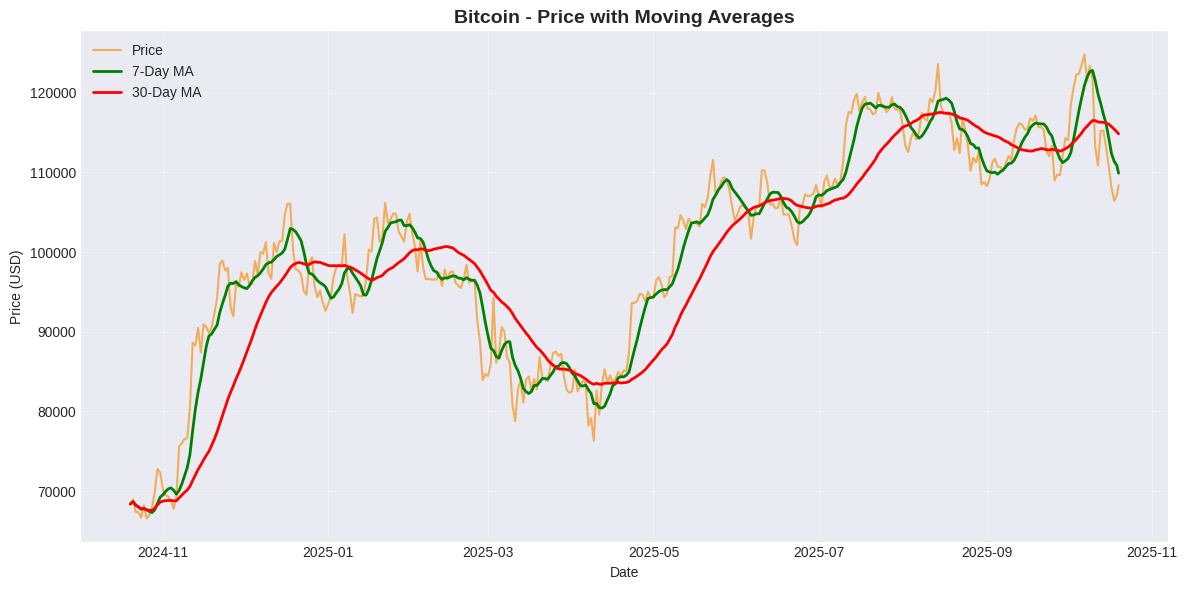

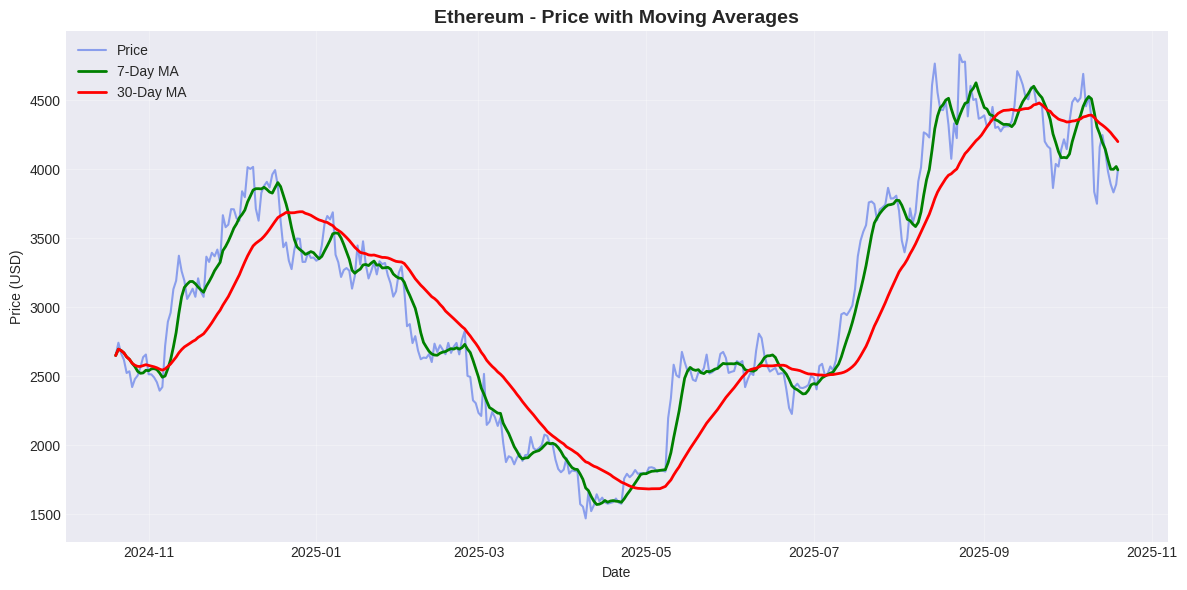

In [19]:
# Plot moving averages for both coins
plot_moving_averages(btc_data, "Bitcoin", '#F7931A')
plot_moving_averages(eth_data, "Ethereum", '#627EEA')

#### Clear Trend Signals
When price crosses above MAs, it often signals strengthening momentum.
When price crosses below MAs, it may signal weakening momentum.

### A5. VOLUME ANALYSIS

Trading volume indicates market activity and liquidity:
- High volume: Strong interest, reliable price movements
- Low volume: Weak interest, potentially less stable prices
- Volume spikes: Often occur during major price moves

In [20]:
def analyse_volume(btc_data, eth_data):
    """Compare volume statistics."""
    print("\nVolume Statistics (USD):")
    print(f"\nBitcoin:")
    print(f"  Average Daily Volume: ${btc_data['volume'].mean():,.0f}")
    print(f"  Median Daily Volume:  ${btc_data['volume'].median():,.0f}")
    print(f"  Max Daily Volume:     ${btc_data['volume'].max():,.0f}")

    print(f"\nEthereum:")
    print(f"  Average Daily Volume: ${eth_data['volume'].mean():,.0f}")
    print(f"  Median Daily Volume:  ${eth_data['volume'].median():,.0f}")
    print(f"  Max Daily Volume:     ${eth_data['volume'].max():,.0f}")

In [21]:
# Analyse volume
analyse_volume(btc_data, eth_data)


Volume Statistics (USD):

Bitcoin:
  Average Daily Volume: $47,168,384,600
  Median Daily Volume:  $40,584,076,434
  Max Daily Volume:     $190,460,293,532

Ethereum:
  Average Daily Volume: $28,366,712,915
  Median Daily Volume:  $25,872,446,688
  Max Daily Volume:     $96,588,727,629


In [22]:
def plot_volume_comparison(btc_data, eth_data):
    """Plot volume comparison."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle('Trading Volume Comparison', fontsize=16, fontweight='bold')

    # Bitcoin volume
    ax1.bar(btc_data['date'], btc_data['volume'] / 1e9,
            color='#F7931A', alpha=0.6, width=1)
    ax1.set_title('Bitcoin Trading Volume', fontweight='bold')
    ax1.set_ylabel('Volume (Billions USD)')
    ax1.grid(True, alpha=0.3, axis='y')

    # Ethereum volume
    ax2.bar(eth_data['date'], eth_data['volume'] / 1e9,
            color='#627EEA', alpha=0.6, width=1)
    ax2.set_title('Ethereum Trading Volume', fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume (Billions USD)')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

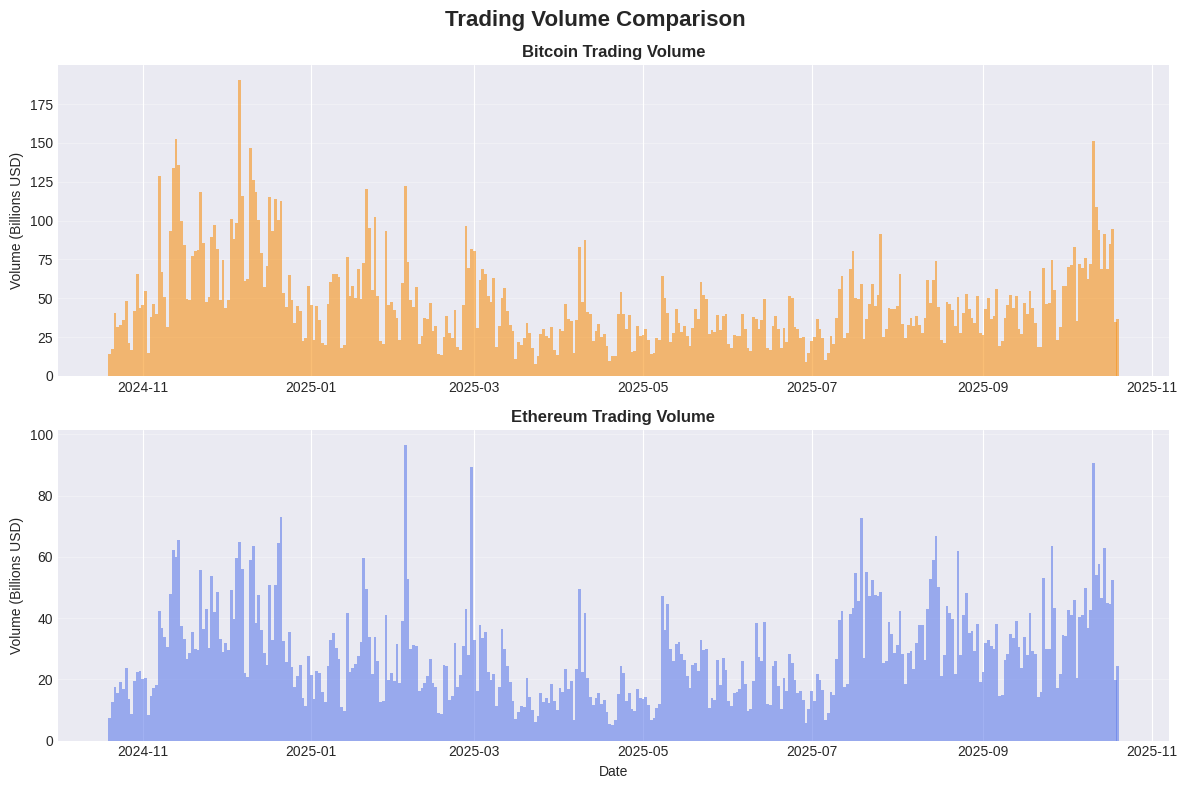

In [23]:
# Plot volume comparison
plot_volume_comparison(btc_data, eth_data)

## PART B: RISK PROFILE ASSESSMENT
OBJECTIVE:

Understand the risk characteristics of BTC and ETH by analyzing:
- Volatility (how much prices fluctuate)
- Downside risk (potential for losses)
- Risk-adjusted returns (return per unit of risk)

### B1. DAILY RETURNS DISTRIBUTION

Daily return = (Today's Price - Yesterday's Price) / Yesterday's Price

- Returns show percentage changes (comparable across assets)
- Distribution of returns reveals risk characteristics
- Normal distribution assumption is key for many risk models

In [24]:
def analyse_returns_distribution(data, coin_name):
    """Analyse return distribution statistics."""
    returns = data['daily_return'].dropna() * 100  # Convert to percentage

    print(f"\n{coin_name} Returns Statistics:")
    print(f"  Mean Daily Return:   {returns.mean():.3f}%")
    print(f"  Median Daily Return: {returns.median():.3f}%")
    print(f"  Std Deviation:       {returns.std():.3f}%")
    print(f"  Skewness:            {stats.skew(returns):.3f}")
    print(f"  Kurtosis:            {stats.kurtosis(returns):.3f}")
    print(f"  Min Return:          {returns.min():.2f}%")
    print(f"  Max Return:          {returns.max():.2f}%")

In [25]:
# Analyse returns

analyse_returns_distribution(btc_data, "Bitcoin")
analyse_returns_distribution(eth_data, "Ethereum")


Bitcoin Returns Statistics:
  Mean Daily Return:   0.153%
  Median Daily Return: 0.028%
  Std Deviation:       2.329%
  Skewness:            0.421
  Kurtosis:            2.761
  Min Return:          -8.63%
  Max Return:          10.15%

Ethereum Returns Statistics:
  Mean Daily Return:   0.192%
  Median Daily Return: 0.089%
  Std Deviation:       4.021%
  Skewness:            0.557
  Kurtosis:            3.519
  Min Return:          -14.66%
  Max Return:          21.39%


#### Bitcoin Returns:
- Skewness: 0.421 → Positive skew = Slight bias toward larger positive returns (good!). More frequent small losses but occasional big gains

- Kurtosis: 2.761 → Near normal (3.0 is perfectly normal). Moderate tail risk - not excessive extreme moves

- Mean (0.153%) > Median (0.028%) → Positive skew. A few large gains pull the average up. Typical day is near-flat (median ~0%)

- Std Dev: 2.329% → Daily volatility of ~2.3%

- Range: -8.63% to +10.15% → Asymmetric (slightly larger upside)


#### Ethereum Returns:
- Skewness: 0.557 → More positive skew than BTC. Even stronger bias toward large positive returns. Greater "lottery ticket" effect

- Kurtosis: 3.519 → Leptokurtic (fat tails). Higher than BTC (2.761) = More extreme events (both directions)

- Mean (0.192%) > Median (0.089%) → Strong positive skew

- Std Dev: 4.021% → Daily volatility of ~4%

- Range: -14.66% to +21.39% → Extreme swings



In [26]:
def plot_returns_distribution(btc_data, eth_data):
    """Plot returns distribution."""
    btc_returns = btc_data['daily_return'].dropna() * 100
    eth_returns = eth_data['daily_return'].dropna() * 100

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Daily Returns Distribution', fontsize=16, fontweight='bold')

    # Bitcoin
    axes[0].hist(btc_returns, bins=50, alpha=0.7, color='#F7931A', edgecolor='black')
    axes[0].axvline(btc_returns.mean(), color='red', linestyle='--',
                    linewidth=2, label=f'Mean: {btc_returns.mean():.2f}%')
    axes[0].axvline(0, color='black', linestyle='-', linewidth=1)
    axes[0].set_title('Bitcoin Returns', fontweight='bold')
    axes[0].set_xlabel('Daily Return (%)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Ethereum
    axes[1].hist(eth_returns, bins=50, alpha=0.7, color='#627EEA', edgecolor='black')
    axes[1].axvline(eth_returns.mean(), color='red', linestyle='--',
                    linewidth=2, label=f'Mean: {eth_returns.mean():.2f}%')
    axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
    axes[1].set_title('Ethereum Returns', fontweight='bold')
    axes[1].set_xlabel('Daily Return (%)')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

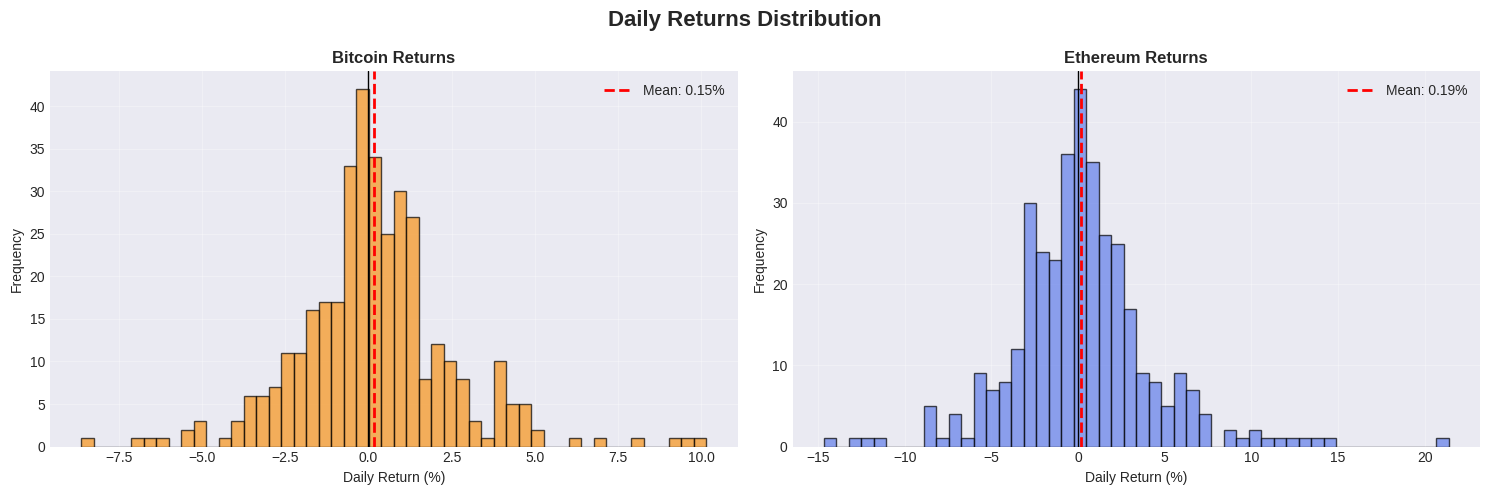

In [27]:
# Plot returns
plot_returns_distribution(btc_data, eth_data)

### B2. VOLATILITY ANALYSIS

Volatility measures how much an asset's price fluctuates:
- Higher volatility = Higher risk (but also higher potential returns)
- Lower volatility = Lower risk (but also lower potential returns)

CALCULATION:
Standard deviation of returns, typically annualized by multiplying by sqrt(365)

In [28]:
def calculate_volatility(data, coin_name):
    """Calculate and display volatility metrics."""
    returns = data['daily_return'].dropna()

    # Daily volatility
    daily_vol = returns.std() * 100

    # Annualized volatility
    annual_vol = daily_vol * np.sqrt(365)

    # Current 30-day volatility
    current_vol_30d = data['volatility_30d'].iloc[-1] * 100 * np.sqrt(365)

    print(f"\n{coin_name} Volatility:")
    print(f"  Daily Volatility:              {daily_vol:.2f}%")
    print(f"  Annualized Volatility:         {annual_vol:.2f}%")
    print(f"  Current 30-Day Vol (annual):   {current_vol_30d:.2f}%")

    return annual_vol

In [29]:
# Calculate volatility
btc_vol = calculate_volatility(btc_data, "Bitcoin")
eth_vol = calculate_volatility(eth_data, "Ethereum")



Bitcoin Volatility:
  Daily Volatility:              2.33%
  Annualized Volatility:         44.49%
  Current 30-Day Vol (annual):   43.34%

Ethereum Volatility:
  Daily Volatility:              4.02%
  Annualized Volatility:         76.83%
  Current 30-Day Vol (annual):   80.85%


#### Ethereum is a Far Riskier Asset
Every risk metric indicates that Ethereum is significantly more volatile than Bitcoin.

Annualized Volatility: Ethereum's volatility (76.83%) is substantially higher than Bitcoin's (44.49%).

Daily Extremes: ETH's best day (+21.39%) and worst day (-14.66%) were both about twice as extreme as Bitcoin's (Max: +10.15%, Min: -8.63%).

Distribution: The "Daily Returns Distribution" histogram visually confirms this. The Ethereum chart is much wider, with "fatter tails" (proven by its higher kurtosis of 3.519). This means extreme price swings, both positive and negative, are far more common for Ethereum.

In [30]:
def plot_rolling_volatility(btc_data, eth_data):
    """Plot 30-day rolling volatility."""
    plt.figure(figsize=(12, 6))
    plt.plot(btc_data['date'], btc_data['volatility_30d'] * 100,
             label='Bitcoin', linewidth=2, color='#F7931A')
    plt.plot(eth_data['date'], eth_data['volatility_30d'] * 100,
             label='Ethereum', linewidth=2, color='#627EEA')

    plt.title('30-Day Rolling Volatility', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

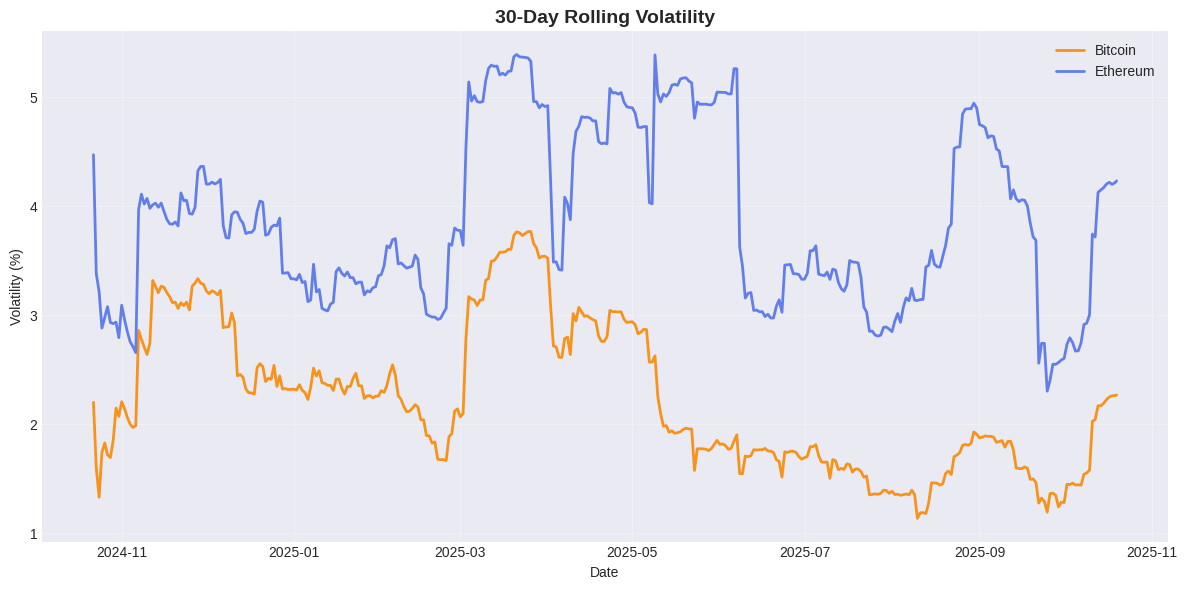

In [31]:
plot_rolling_volatility(btc_data, eth_data)

Volatility changes over time - it's not constant!
High volatility periods often coincide with major market events.

### B3. DRAWDOWN ANALYSIS

A drawdown measures the decline from a peak to a trough:
- Shows worst-case historical losses
- Maximum drawdown = largest peak-to-trough decline
- Important for understanding downside risk

FORMULA:
Drawdown = (Current Value - Peak Value) / Peak Value

In [32]:
def calculate_drawdown(data, coin_name):
    """Calculate and display drawdown metrics."""
    returns = data['daily_return'].dropna()

    # Calculate cumulative returns
    cumulative = (1 + returns).cumprod()

    # Calculate running maximum
    running_max = cumulative.expanding().max()

    # Calculate drawdown
    drawdown = (cumulative - running_max) / running_max

    # Maximum drawdown
    max_dd = drawdown.min() * 100

    # Current drawdown
    current_dd = drawdown.iloc[-1] * 100

    print(f"\n{coin_name} Drawdown Analysis:")
    print(f"  Maximum Drawdown:  {max_dd:.2f}%")
    print(f"  Current Drawdown:  {current_dd:.2f}%")

    # Find longest drawdown period
    in_drawdown = drawdown < 0
    drawdown_periods = []
    start = None

    for i, val in enumerate(in_drawdown):
        if val and start is None:
            start = i
        elif not val and start is not None:
            drawdown_periods.append(i - start)
            start = None

    if drawdown_periods:
        print(f"  Longest Drawdown:  {max(drawdown_periods)} days")

    return drawdown

In [33]:
# Calculate drawdown
btc_dd = calculate_drawdown(btc_data, "Bitcoin")
eth_dd = calculate_drawdown(eth_data, "Ethereum")



Bitcoin Drawdown Analysis:
  Maximum Drawdown:  -28.12%
  Current Drawdown:  -13.13%
  Longest Drawdown:  118 days

Ethereum Drawdown Analysis:
  Maximum Drawdown:  -63.36%
  Current Drawdown:  -17.35%
  Longest Drawdown:  243 days


#### Bitcoin Was Much More Resilient
This is the most significant insight. While their returns were similar, their risk profiles were vastly different.

- Maximum Drawdown: Ethereum's maximum loss from a peak was a staggering -63.36%. Bitcoin's, while still large, was less than half that at -28.12%.

- Recovery Time: It took Ethereum investors 243 days to recover from a peak (longest drawdown), more than double the time it took Bitcoin investors (118 days).

In [34]:
def plot_drawdown(btc_data, eth_data):
    """Plot drawdown for both assets."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle('Drawdown Analysis', fontsize=16, fontweight='bold')

    # Bitcoin
    btc_returns = btc_data['daily_return'].dropna().reset_index(drop=True)
    btc_cumulative = (1 + btc_returns).cumprod()
    btc_running_max = btc_cumulative.expanding().max()
    btc_drawdown = ((btc_cumulative - btc_running_max) / btc_running_max) * 100

    ax1.fill_between(range(len(btc_drawdown)), btc_drawdown, 0,
                     alpha=0.6, color='#F7931A')
    ax1.set_title('Bitcoin Drawdown', fontweight='bold')
    ax1.set_ylabel('Drawdown (%)')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([btc_drawdown.min() * 1.1, 5])

    # Ethereum
    eth_returns = eth_data['daily_return'].dropna().reset_index(drop=True)
    eth_cumulative = (1 + eth_returns).cumprod()
    eth_running_max = eth_cumulative.expanding().max()
    eth_drawdown = ((eth_cumulative - eth_running_max) / eth_running_max) * 100

    ax2.fill_between(range(len(eth_drawdown)), eth_drawdown, 0,
                     alpha=0.6, color='#627EEA')
    ax2.set_title('Ethereum Drawdown', fontweight='bold')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([eth_drawdown.min() * 1.1, 5])

    plt.tight_layout()
    plt.show()


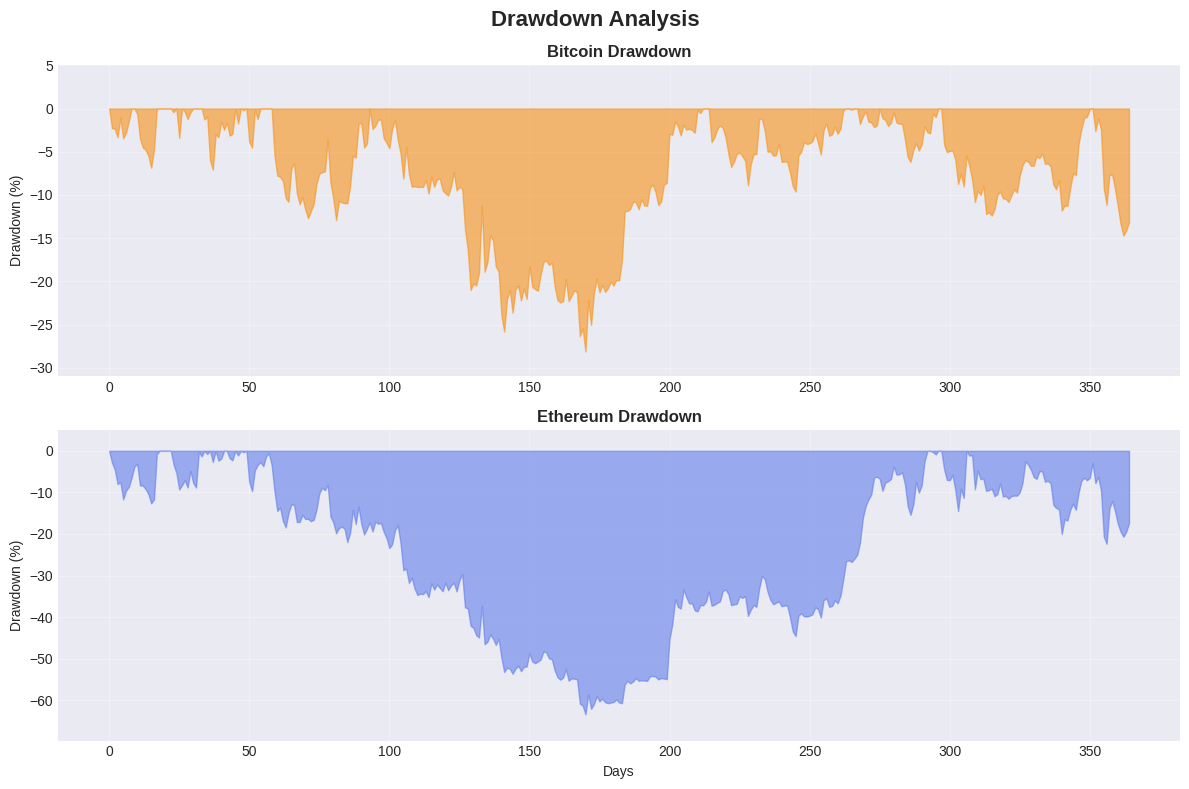

In [35]:
# Plot drawdown
plot_drawdown(btc_data, eth_data)

### B4. VALUE AT RISK (VaR)

VaR answers: "What is the maximum loss I can expect X% of the time?"

Example: 95% VaR of -3% means:
- 95% of the time, you won't lose more than 3%
- 5% of the time, you might lose more than 3%

CONDITIONAL VaR (CVaR):

Also called "Expected Shortfall" - the average loss when VaR is exceeded


In [36]:
def calculate_var(data, coin_name, confidence=95):
    """Calculate Value at Risk metrics."""
    returns = data['daily_return'].dropna() * 100

    # VaR at given confidence level
    var = np.percentile(returns, 100 - confidence)

    # Conditional VaR (Expected Shortfall)
    cvar = returns[returns <= var].mean()

    print(f"\n{coin_name} Risk Metrics ({confidence}% Confidence):")
    print(f"  Value at Risk (VaR):         {var:.2f}%")
    print(f"  Conditional VaR (CVaR):      {cvar:.2f}%")
    print(f"  Interpretation: On the worst {100-confidence}% of days:")
    print(f"    - You can expect to lose at least {abs(var):.2f}%")
    print(f"    - Average loss is {abs(cvar):.2f}%")


In [37]:
# Calculate VaR
calculate_var(btc_data, "Bitcoin", confidence=95)
calculate_var(eth_data, "Ethereum", confidence=95)


Bitcoin Risk Metrics (95% Confidence):
  Value at Risk (VaR):         -3.39%
  Conditional VaR (CVaR):      -4.83%
  Interpretation: On the worst 5% of days:
    - You can expect to lose at least 3.39%
    - Average loss is 4.83%

Ethereum Risk Metrics (95% Confidence):
  Value at Risk (VaR):         -5.62%
  Conditional VaR (CVaR):      -8.30%
  Interpretation: On the worst 5% of days:
    - You can expect to lose at least 5.62%
    - Average loss is 8.30%


#### Ethereum's worst-case losses are dramatically more severe than Bitcoin's.

When those bad days happen, the average loss on ETH is -8.30%, far deeper than BTC's average loss of -4.83%.

This confirms that Ethereum carries significantly more tail risk (the risk of extreme negative events).

### B5. RISK-ADJUSTED RETURNS

High returns don't mean much if they come with extreme risk.
Risk-adjusted metrics help us compare investments fairly.

SHARPE RATIO:
= (Mean Return - Risk-Free Rate) / Standard Deviation
- Measures return per unit of total risk
- Higher is better

... > 1 is good, > 2 is very good, > 3 is excellent

SORTINO RATIO:
= (Mean Return - Risk-Free Rate) / Downside Deviation
- Only penalizes downside volatility (losses)
- Higher is better than Sharpe

In [38]:
def calculate_risk_adjusted_returns(data, coin_name, risk_free_rate=0):
    """Calculate Sharpe and Sortino ratios."""
    returns = data['daily_return'].dropna()

    mean_return = returns.mean()
    std_return = returns.std()

    # Sharpe Ratio (annualized)
    sharpe = ((mean_return - risk_free_rate) / std_return) * np.sqrt(365)

    # Sortino Ratio (annualized)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std()
    sortino = ((mean_return - risk_free_rate) / downside_std) * np.sqrt(365)

    # Win rate
    positive_days = (returns > 0).sum()
    total_days = len(returns)
    win_rate = (positive_days / total_days) * 100

    print(f"\n{coin_name} Risk-Adjusted Performance:")
    print(f"  Mean Daily Return:     {mean_return * 100:.3f}%")
    print(f"  Annualized Return:     {mean_return * 365 * 100:.2f}%")
    print(f"  Sharpe Ratio:          {sharpe:.3f}")
    print(f"  Sortino Ratio:         {sortino:.3f}")
    print(f"  Win Rate:              {win_rate:.1f}%")

    return sharpe, sortino

In [39]:
# Calculate risk-adjusted returns
btc_sharpe, btc_sortino = calculate_risk_adjusted_returns(btc_data, "Bitcoin")
eth_sharpe, eth_sortino = calculate_risk_adjusted_returns(eth_data, "Ethereum")



Bitcoin Risk-Adjusted Performance:
  Mean Daily Return:     0.153%
  Annualized Return:     55.88%
  Sharpe Ratio:          1.256
  Sortino Ratio:         1.942
  Win Rate:              51.2%

Ethereum Risk-Adjusted Performance:
  Mean Daily Return:     0.192%
  Annualized Return:     70.05%
  Sharpe Ratio:          0.912
  Sortino Ratio:         1.445
  Win Rate:              51.5%


#### Bitcoin provided a better return for the amount of risk taken.

- Raw Return: Ethereum had a higher annualized return (70.05%) than Bitcoin (55.88%).

- Sharpe Ratio (Overall Risk): Bitcoin's Sharpe Ratio (1.256) is much higher than Ethereum's (0.912). This means Bitcoin delivered more return per unit of total volatility.

- Sortino Ratio (Downside Risk): Bitcoin's Sortino Ratio (1.942) is also significantly higher than Ethereum's (1.445). This is even more telling, as it shows Bitcoin delivered superior returns when only factoring in downside risk (bad days).

## PART C: CORRELATION ANALYSIS

OBJECTIVE:

Understand how BTC and ETH move together:
- Do they move in the same direction?
- How strong is their relationship?
- Does this relationship change over time?
- Can we use this for diversification?

### C1. PREPARE DATA FOR CORRELATION

To calculate correlation, we need matching dates for both assets.
We merge BTC and ETH returns on the same dates for direct comparison.

In [40]:
def prepare_correlation_data(btc_data, eth_data):
    """Merge BTC and ETH data for correlation analysis."""
    # Extract returns with dates
    btc_returns = btc_data[['date', 'daily_return']].copy()
    btc_returns.columns = ['date', 'btc_return']

    eth_returns = eth_data[['date', 'daily_return']].copy()
    eth_returns.columns = ['date', 'eth_return']

    # Merge on date
    merged = pd.merge(btc_returns, eth_returns, on='date', how='inner')

    # Remove any missing values
    merged = merged.dropna()

    print(f"\nMerged dataset:")
    print(f"  Total observations: {len(merged)}")
    print(f"  Date range: {merged['date'].min()} to {merged['date'].max()}")
    print(f"\nFirst few rows:")
    print(merged.head())

    return merged

In [41]:
merged_data = prepare_correlation_data(btc_data, eth_data)


Merged dataset:
  Total observations: 364
  Date range: 2024-10-21 00:00:00 to 2025-10-19 00:00:00

First few rows:
        date  btc_return  eth_return
1 2024-10-21    0.008393    0.035087
2 2024-10-22   -0.022736   -0.028155
3 2024-10-23   -0.000650   -0.017319
4 2024-10-24   -0.009905   -0.036442
5 2024-10-25    0.022945    0.004806


### C2. CALCULATE CORRELATION COEFFICIENTS

CORRELATION MEASURES:
1. Pearson Correlation: Measures linear relationship
   - Range: -1 to +1
   - +1 = Perfect positive correlation (move together)
   -  0 = No linear relationship
   - -1 = Perfect negative correlation (move opposite)

2. Spearman Correlation: Measures monotonic relationship
   - More robust to outliers
   - Useful for non-linear relationships

INTERPRETATION:
- |r| > 0.7: Strong correlation
- |r| 0.4-0.7: Moderate correlation  
- |r| < 0.4: Weak correlation

In [42]:
def calculate_correlations(merged_data):
    """Calculate different correlation measures."""
    btc_ret = merged_data['btc_return']
    eth_ret = merged_data['eth_return']

    # Pearson correlation
    pearson_corr, pearson_p = stats.pearsonr(btc_ret, eth_ret)

    # Spearman correlation
    spearman_corr, spearman_p = stats.spearmanr(btc_ret, eth_ret)

    print("\nCorrelation Results:")
    print(f"\nPearson Correlation:  {pearson_corr:.4f}")
    print(f"  P-value:            {pearson_p:.6f}")
    if pearson_p < 0.05:
        print(f"  Statistically significant at 95% confidence")

    print(f"\nSpearman Correlation: {spearman_corr:.4f}")
    print(f"  P-value:            {spearman_p:.6f}")

    # Interpret strength
    strength = "Strong" if abs(pearson_corr) > 0.7 else "Moderate" if abs(pearson_corr) > 0.4 else "Weak"
    direction = "positive" if pearson_corr > 0 else "negative"

    print(f"\nInterpretation: {strength} {direction} correlation")
    print(f"This means BTC and ETH tend to move {'together' if pearson_corr > 0 else 'in opposite directions'}")

    return pearson_corr

In [43]:
overall_corr = calculate_correlations(merged_data)


Correlation Results:

Pearson Correlation:  0.7792
  P-value:            0.000000
  Statistically significant at 95% confidence

Spearman Correlation: 0.7299
  P-value:            0.000000

Interpretation: Strong positive correlation
This means BTC and ETH tend to move together


### C3. VISUALIZE CORRELATION - SCATTER PLOT

Scatter plots show the relationship visually:
- Each point represents one day
- Pattern shows how returns move together
- Regression line shows average relationship

In [44]:
def plot_correlation_scatter(merged_data):
    """Create scatter plot of BTC vs ETH returns."""
    btc_ret = merged_data['btc_return'] * 100
    eth_ret = merged_data['eth_return'] * 100

    plt.figure(figsize=(10, 8))

    # Scatter plot
    plt.scatter(btc_ret, eth_ret, alpha=0.5, s=30, color='#627EEA')

    # Add regression line
    z = np.polyfit(btc_ret, eth_ret, 1)
    p = np.poly1d(z)
    x_line = np.linspace(btc_ret.min(), btc_ret.max(), 100)
    plt.plot(x_line, p(x_line), "r--", linewidth=2, label='Regression Line')

    # Add reference lines
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    plt.title('BTC vs ETH Daily Returns Correlation',
              fontsize=14, fontweight='bold')
    plt.xlabel('Bitcoin Daily Return (%)')
    plt.ylabel('Ethereum Daily Return (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

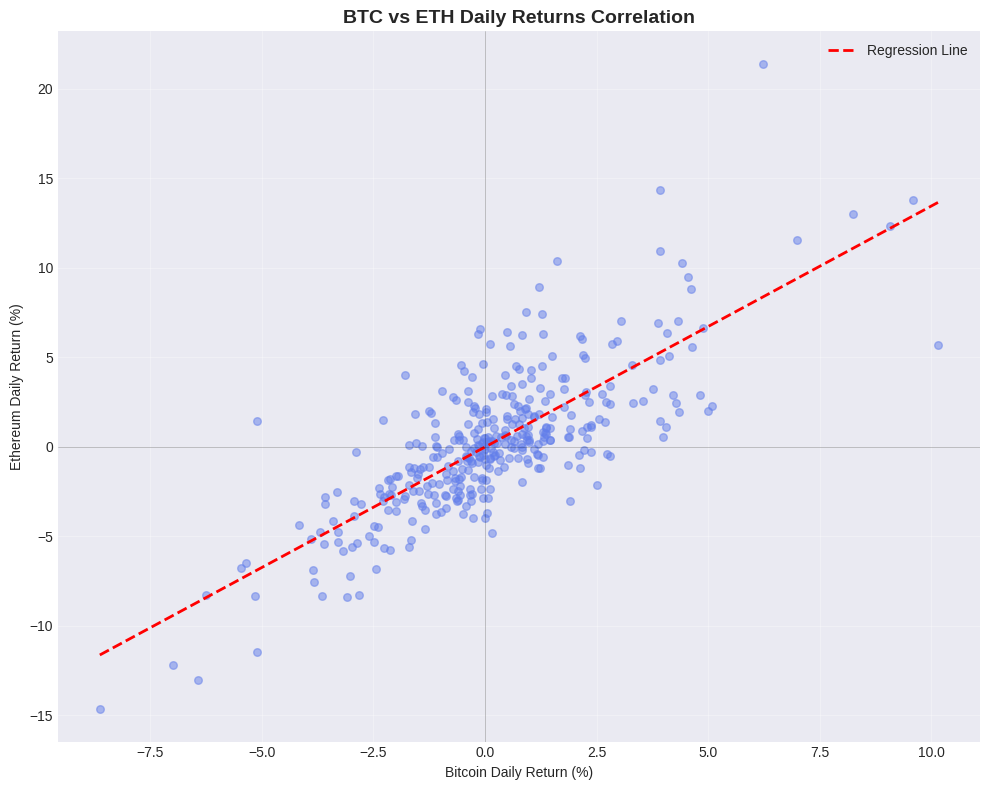

In [45]:
plot_correlation_scatter(merged_data)

### C4. ROLLING CORRELATION

Correlation isn't constant - it changes over time!
- Market conditions affect relationships
- Crisis periods often see higher correlation
- Bull markets may have different correlation than bear markets

METHOD:
Calculate correlation over a moving 30-day window

In [46]:
def calculate_rolling_correlation(merged_data, window=30):
    """Calculate and analyze rolling correlation."""
    btc_ret = merged_data['btc_return']
    eth_ret = merged_data['eth_return']

    # Calculate rolling correlation
    rolling_corr = btc_ret.rolling(window=window).corr(eth_ret)

    print(f"\nRolling Correlation Statistics ({window}-day window):")
    print(f"  Current:  {rolling_corr.iloc[-1]:.4f}")
    print(f"  Mean:     {rolling_corr.mean():.4f}")
    print(f"  Median:   {rolling_corr.median():.4f}")
    print(f"  Min:      {rolling_corr.min():.4f}")
    print(f"  Max:      {rolling_corr.max():.4f}")
    print(f"  Std Dev:  {rolling_corr.std():.4f}")

    # Find periods of highest/lowest correlation
    max_idx = rolling_corr.idxmax()
    min_idx = rolling_corr.idxmin()

    print(f"\n  Highest correlation: {rolling_corr.max():.4f} on day {max_idx}")
    print(f"  Lowest correlation:  {rolling_corr.min():.4f} on day {min_idx}")

    return rolling_corr

In [47]:
rolling_corr = calculate_rolling_correlation(merged_data, window=30)


Rolling Correlation Statistics (30-day window):
  Current:  0.9313
  Mean:     0.7716
  Median:   0.7808
  Min:      0.4390
  Max:      0.9567
  Std Dev:  0.1127

  Highest correlation: 0.9567 on day 180
  Lowest correlation:  0.4390 on day 295


In [48]:
def plot_rolling_correlation(merged_data, rolling_corr):
    """Plot rolling correlation over time."""
    plt.figure(figsize=(12, 6))

    plt.plot(merged_data['date'].iloc[29:], rolling_corr.iloc[29:],
             linewidth=2, color='#F7931A')
    plt.axhline(y=rolling_corr.mean(), color='green', linestyle='--',
               alpha=0.7, linewidth=2, label=f'Mean: {rolling_corr.mean():.3f}')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

    plt.title('30-Day Rolling Correlation: BTC vs ETH',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Correlation Coefficient')
    plt.ylim([0, 1])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

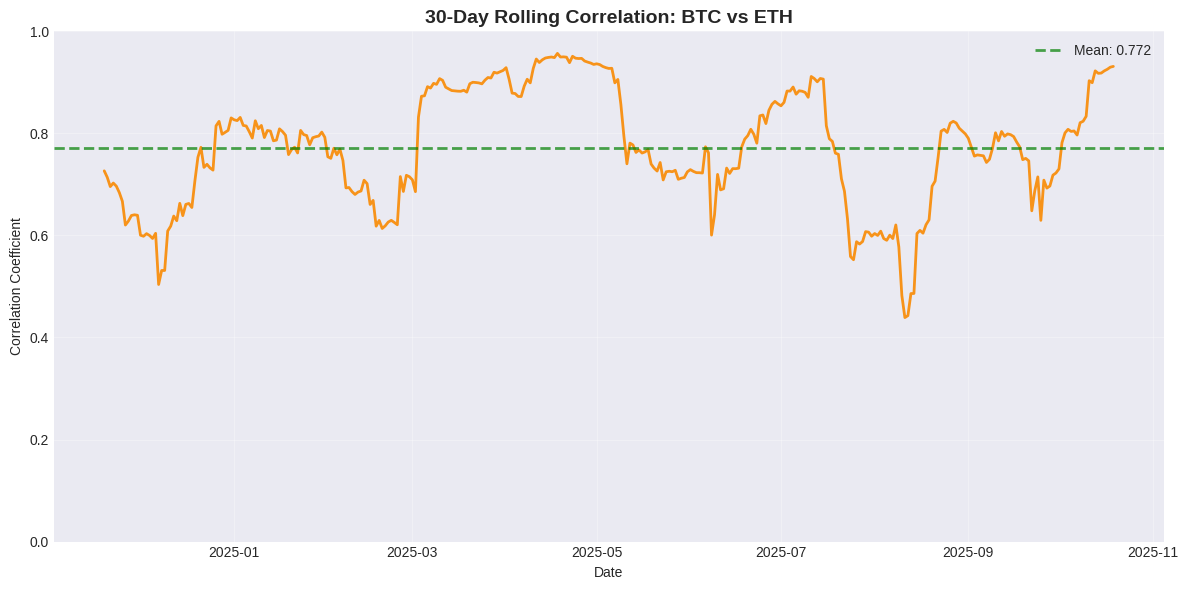

In [49]:
plot_rolling_correlation(merged_data, rolling_corr)

The correlation isn't static. It fluctuated significantly over the year, reaching highs near 1.0 (perfect correlation) and dropping to lows around 0.45.

### C5. CORRELATION IN DIFFERENT MARKET CONDITIONS

DO BTC AND ETH CORRELATE DIFFERENTLY IN BULL VS BEAR MARKETS?

We'll analyse correlation in three scenarios:
1. Bull Market: Both assets have positive returns
2. Bear Market: Both assets have negative returns
3. Mixed: One up, one down

In [50]:
def analyse_market_conditions(merged_data):
    """Analyse correlation under different market conditions."""
    btc_ret = merged_data['btc_return']
    eth_ret = merged_data['eth_return']

    # Define market conditions
    bull_mask = (btc_ret > 0) & (eth_ret > 0)
    bear_mask = (btc_ret < 0) & (eth_ret < 0)
    mixed_mask = ((btc_ret > 0) & (eth_ret < 0)) | ((btc_ret < 0) & (eth_ret > 0))

    bull_days = bull_mask.sum()
    bear_days = bear_mask.sum()
    mixed_days = mixed_mask.sum()
    total_days = len(merged_data)

    print("\nMarket Condition Distribution:")
    print(f"  Bull Days (both up):    {bull_days} ({bull_days/total_days*100:.1f}%)")
    print(f"  Bear Days (both down):  {bear_days} ({bear_days/total_days*100:.1f}%)")
    print(f"  Mixed Days:             {mixed_days} ({mixed_days/total_days*100:.1f}%)")

    # Calculate correlations for each condition
    if bull_days > 10:
        bull_corr, _ = stats.pearsonr(btc_ret[bull_mask], eth_ret[bull_mask])
        print(f"\n  Bull Market Correlation:  {bull_corr:.4f}")

    if bear_days > 10:
        bear_corr, _ = stats.pearsonr(btc_ret[bear_mask], eth_ret[bear_mask])
        print(f"  Bear Market Correlation:  {bear_corr:.4f}")

    if mixed_days > 10:
        mixed_corr, _ = stats.pearsonr(btc_ret[mixed_mask], eth_ret[mixed_mask])
        print(f"  Mixed Market Correlation: {mixed_corr:.4f}")

In [51]:
analyse_market_conditions(merged_data)


Market Condition Distribution:
  Bull Days (both up):    143 (39.3%)
  Bear Days (both down):  134 (36.8%)
  Mixed Days:             87 (23.9%)

  Bull Market Correlation:  0.6101
  Bear Market Correlation:  0.8270
  Mixed Market Correlation: -0.4093


The correlation between the assets spikes to a very strong 0.8270 on "bear days," meaning they crash together. This is significantly higher than their correlation on "bull days" (0.6101).

True diversification, where one asset goes up and the other goes down, is rare, happening only 23.9% of the time.

### C6. LEAD-LAG RELATIONSHIP
DOES ONE ASSET LEAD THE OTHER?

Lead-lag analysis checks if:
- Bitcoin moves first, then Ethereum follows
- Ethereum moves first, then Bitcoin follows
- They move simultaneously

This can reveal market dynamics and information flow.


In [52]:
def analyse_lead_lag(merged_data, max_lag=5):
    """Analyse lead-lag relationships."""
    btc_ret = merged_data['btc_return']
    eth_ret = merged_data['eth_return']

    correlations = []

    print(f"\nLead-Lag Analysis (up to {max_lag} days):")
    print("\n  Lag  |  Correlation  |  Interpretation")
    print("  " + "-"*50)

    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            # BTC leads ETH
            corr = btc_ret.iloc[:-abs(lag)].corr(eth_ret.iloc[abs(lag):])
            leader = "BTC leads"
        elif lag > 0:
            # ETH leads BTC
            corr = eth_ret.iloc[:-lag].corr(btc_ret.iloc[lag:])
            leader = "ETH leads"
        else:
            corr = btc_ret.corr(eth_ret)
            leader = "Simultaneous"

        correlations.append((lag, corr, leader))
        print(f"  {lag:3d}  |  {corr:7.4f}     |  {leader}")


    return correlations

In [53]:
lead_lag_results = analyse_lead_lag(merged_data, max_lag=5)


Lead-Lag Analysis (up to 5 days):

  Lag  |  Correlation  |  Interpretation
  --------------------------------------------------
   -5  |   0.7785     |  BTC leads
   -4  |   0.7781     |  BTC leads
   -3  |   0.7788     |  BTC leads
   -2  |   0.7788     |  BTC leads
   -1  |   0.7793     |  BTC leads
    0  |   0.7792     |  Simultaneous
    1  |   0.7793     |  ETH leads
    2  |   0.7788     |  ETH leads
    3  |   0.7788     |  ETH leads
    4  |   0.7781     |  ETH leads
    5  |   0.7785     |  ETH leads


The correlations are virtually identical across all lags! Bitcoin and Ethereum move SIMULTANEOUSLY, not sequentially



### C7. CUMULATIVE RETURNS COMPARISON

Cumulative returns show how $1 invested grows over time:
- Makes it easy to compare total performance
- Shows which asset had better overall returns
- Helps visualize divergence/convergence

In [54]:
def plot_cumulative_returns(btc_data, eth_data):
    """Plot cumulative returns for both assets using pre-calculated values."""
    # Use the cumulative_return column from pipeline
    btc_cumulative = btc_data['cumulative_return']
    eth_cumulative = eth_data['cumulative_return']

    plt.figure(figsize=(12, 6))

    plt.plot(btc_data['date'], btc_cumulative,
             label='Bitcoin', linewidth=2, color='#F7931A')
    plt.plot(eth_data['date'], eth_cumulative,
             label='Ethereum', linewidth=2, color='#627EEA')

    plt.axhline(y=1, color='black', linestyle='--',
               linewidth=1, alpha=0.3, label='Starting Point')

    plt.title('Cumulative Returns: $1 Invested',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate final values
    btc_final = btc_cumulative.iloc[-1]
    eth_final = eth_cumulative.iloc[-1]

    print(f"\nCumulative Returns:")
    print(f"  Bitcoin:  ${btc_final:.2f} ({(btc_final-1)*100:+.1f}%)")
    print(f"  Ethereum: ${eth_final:.2f} ({(eth_final-1)*100:+.1f}%)")

    if btc_final > eth_final:
        print(f"\n  Bitcoin outperformed by ${btc_final - eth_final:.2f}")
    else:
        print(f"\n  Ethereum outperformed by ${eth_final - btc_final:.2f}")

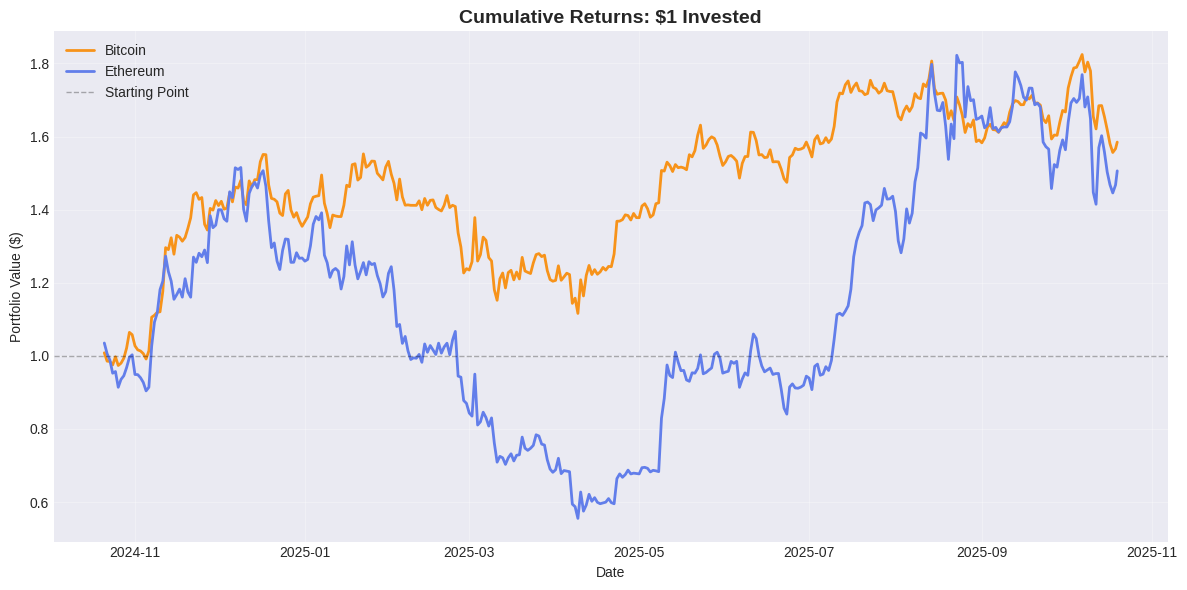


Cumulative Returns:
  Bitcoin:  $1.58 (+58.5%)
  Ethereum: $1.51 (+50.6%)

  Bitcoin outperformed by $0.08


In [55]:
plot_cumulative_returns(btc_data, eth_data)

### C8. MONTHLY CORRELATION

HOW DOES CORRELATION VARY BY MONTH?

This helps identify:
- Seasonal patterns in correlation
- Periods of high/low correlation
- Recent trends vs historical average


In [56]:
def analyse_monthly_correlation(merged_data):
    """Calculate and visualize monthly correlation."""
    # Add year-month column
    merged_data['year_month'] = merged_data['date'].dt.to_period('M')

    # Calculate monthly correlation
    monthly_corr = merged_data.groupby('year_month').apply(
        lambda x: x['btc_return'].corr(x['eth_return']) if len(x) > 10 else np.nan
    ).reset_index()
    monthly_corr.columns = ['year_month', 'correlation']
    monthly_corr = monthly_corr.dropna()
    monthly_corr['year_month_str'] = monthly_corr['year_month'].astype(str)

    print(f"\nMonthly Correlation Statistics:")
    print(f"  Mean:   {monthly_corr['correlation'].mean():.4f}")
    print(f"  Median: {monthly_corr['correlation'].median():.4f}")
    print(f"  Min:    {monthly_corr['correlation'].min():.4f}")
    print(f"  Max:    {monthly_corr['correlation'].max():.4f}")

    # Show recent months
    print(f"\nRecent 6 Months:")
    for _, row in monthly_corr.tail(6).iterrows():
        print(f"  {row['year_month_str']}: {row['correlation']:.4f}")

    return monthly_corr

In [57]:
monthly_corr = analyse_monthly_correlation(merged_data)


Monthly Correlation Statistics:
  Mean:   0.7882
  Median: 0.7919
  Min:    0.6073
  Max:    0.9435

Recent 6 Months:
  2025-05: 0.7251
  2025-06: 0.8579
  2025-07: 0.6073
  2025-08: 0.8029
  2025-09: 0.7224
  2025-10: 0.9435


In [58]:
def plot_monthly_correlation(monthly_corr):
    """Plot monthly correlation as bar chart."""
    # Get last 12 months
    monthly_recent = monthly_corr.tail(12)

    plt.figure(figsize=(12, 6))

    colors = ['green' if x > monthly_corr['correlation'].mean()
              else 'red' for x in monthly_recent['correlation']]

    bars = plt.bar(range(len(monthly_recent)), monthly_recent['correlation'],
                   color=colors, alpha=0.7, edgecolor='black')

    plt.axhline(y=monthly_corr['correlation'].mean(), color='blue',
               linestyle='--', linewidth=2,
               label=f'Overall Mean: {monthly_corr["correlation"].mean():.3f}')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    plt.title('Monthly Correlation: BTC vs ETH (Last 12 Months)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(range(len(monthly_recent)), monthly_recent['year_month_str'],
               rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

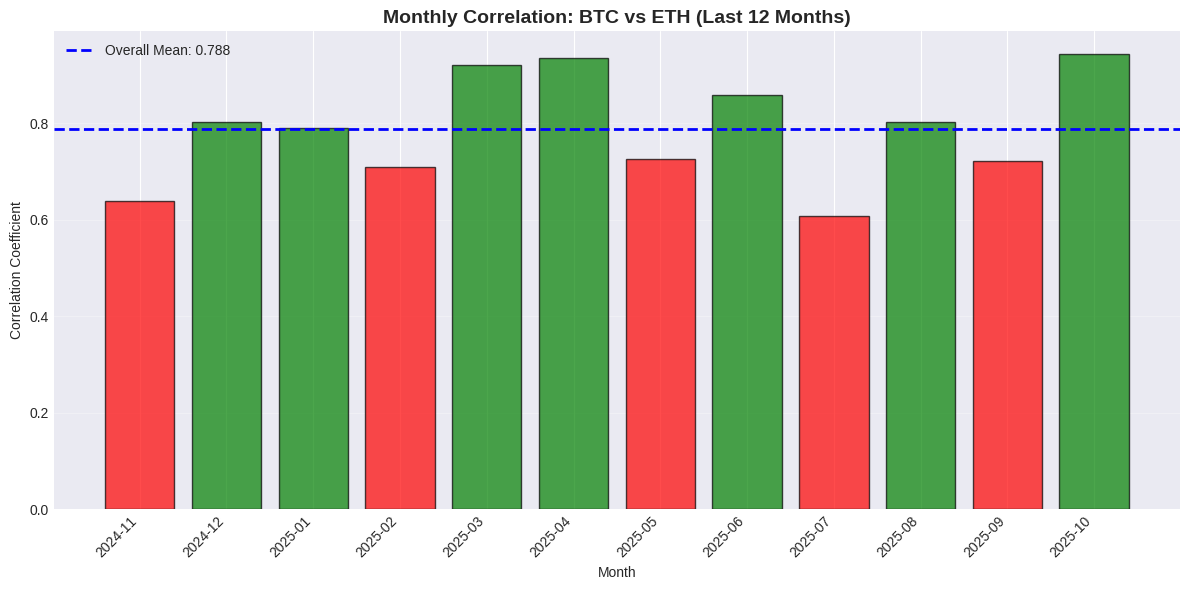

In [59]:
plot_monthly_correlation(monthly_corr)

#### Correlation is NOT Stable

The chart shows significant month-to-month swings, from a low of 0.6073 to a high of 0.9435.

- Recent Decoupling and Recoupling: The most interesting trend occurred in the last few months. The correlation hit its lowest point of the year in July 2025 (0.6073), indicating the assets were moving their most independently.

- Current State - Near-Perfect Lockstep: Following that low, the correlation has dramatically reversed, spiking to 0.9435 in October 2025. This was the highest correlation of the year, meaning that in the most recent market environment, the assets are moving in almost perfect unison.

## RECOMMENDATIONS

1. FURTHER ANALYSIS TO CONSIDER:

   • Backtesting trading strategies

   • Portfolio optimization (finding optimal BTC/ETH allocation)

   • On-chain metrics analysis

   • Sentiment analysis from social media

   • Comparison with traditional assets (stocks, gold)

2. DATA UPDATES:

   • Rerun this analysis monthly to track changes

   • Monitor correlation during market events

   • Update risk metrics as new data arrives

3. RISK MANAGEMENT:

   • Set position size limits based on volatility

   • Use stop-losses to limit downside

   • Consider rebalancing triggers

   • Diversify beyond just BTC and ETH

4. TOOLS FOR LIVE MONITORING:

   • Set up automated data pipeline

   • Create dashboard for key metrics

   • Configure alerts for correlation changes
   
   • Track portfolio performance